# Import and init

In [94]:
import os 
import json

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk 
from nltk.corpus import stopwords

In [95]:
INPUT_DATA_URL = 'https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv'
INPUT_DATA_RELPATH = 'data/input/tmdb_5000_movies.csv'


In [96]:
def download_file(url: str, 
                  filename: str
                  ) -> None:
    """
    Downloads a file from a given URL using the requests module.

    Args:
        url (str): The URL of the file to download.
        filename (str): The local path and name to save the file as.
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes (4XX or 5XX)

        # Open the file in binary write mode and write the content
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                # If you want a progress bar, you'd add logic here
                f.write(chunk)
        print(f"File '{filename}' downloaded successfully.")

    except requests.exceptions.RequestException as e:
        print(f"Download failed: {e}")

# Data

## Download dataset

In [97]:
input_data_relpath_directory = os.path.split(INPUT_DATA_RELPATH)[0]
if input_data_relpath_directory and not os.path.exists(input_data_relpath_directory):
    print(f'Creating directory: {input_data_relpath_directory}')
    os.makedirs(input_data_relpath_directory)

In [98]:
if not os.path.exists(INPUT_DATA_RELPATH):
    download_file(
        INPUT_DATA_URL, 
        INPUT_DATA_RELPATH
    )
else:
    print(f'File already present in {INPUT_DATA_RELPATH}')

File already present in data/input/tmdb_5000_movies.csv


## Read data

In [99]:
df0 = pd.read_csv(INPUT_DATA_RELPATH)
df0

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

## EDA (`df0`)

### Overall

In [100]:
print(f"""- Number of rows: {len(df0)}
""")

- Number of rows: 4803



In [101]:
df0.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

All columns:
- budget                int64
- genres                str
- homepage              str
- id                    int64
- keywords              str
- original_language     str
- original_title        str
- overview              str
- popularity            float64
- production_companies  str
- production_countries  str
- release_date          str
- revenue               int64
- runtime               float64
- spoken_languages      str
- status                str
- tagline               str
- title                 str
- vote_average          float64
- vote_count            int64


array([[<Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'popularity'}>],
       [<Axes: title={'center': 'revenue'}>,
        <Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'vote_average'}>],
       [<Axes: title={'center': 'vote_count'}>, <Axes: >, <Axes: >]],
      dtype=object)

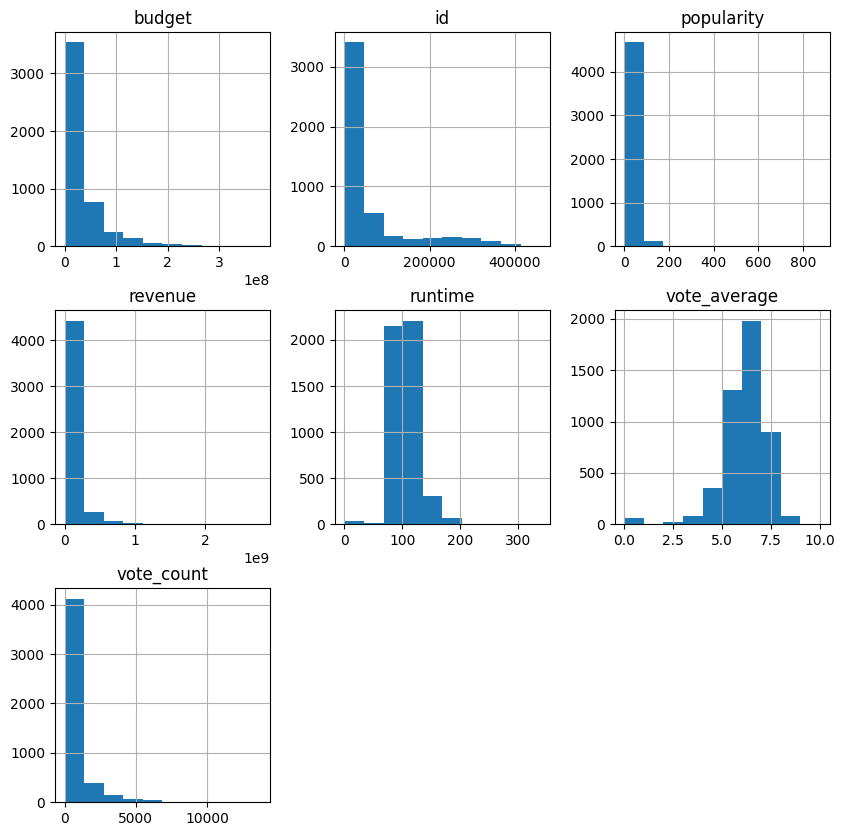

In [102]:
def EDA_plots(df):
    # Print all columns
    print(f"All columns:")
    max_len = max(len(i) for i in list(df.columns))
    for i in list(df.columns):
        how_many_spaces = max_len - len(i)
        print(f"- {i}{' '*how_many_spaces}  {df[i].dtypes}")
    # Make histograms for numeric variables
    display(df.hist(figsize=(10, 10)));
    # Plot categorical values
    for i in list(df.select_dtypes(include = 'category').columns.tolist()):
        plt.figure(
            figsize=(5, 5)
        );
        df[[i]].value_counts().plot(kind = 'barh');
        plt.show();
    return None

EDA_plots(df0)

### overview

<Axes: ylabel='Count'>

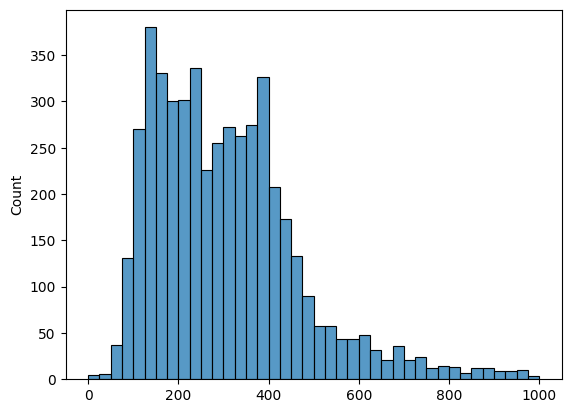

In [103]:
def proc1(x):
    if not pd.isnull(x):
        return len(x)
    return 0

sns.histplot(
    df0['overview'].apply(lambda x: proc1(x)).tolist()
)


### json fields

In [104]:
# some fields are formatted in what looks like 
# json-formatted values with multiple values per row
json_fields = ['genres', 'keywords', 'spoken_languages']
df0[json_fields].head(3)

,genres,keywords,spoken_languages
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""iso_639_1"": ""en"", ""name"": ""English""}]"
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},..."


In [105]:
for i in json_fields:
    print(f'Field "{i}"')
    print('- Json-loaded string:')
    json_proc1 = json.loads(
        df0[i][0]
    )
    print(json_proc1)
    print(f'- Unique keys present: {set([item for sublist in json_proc1 for item in sublist])}')
    print('- Only getting values for the key "name":')
    print([i['name'] for i in json_proc1], '\n')


Field "genres"
- Json-loaded string:
[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 878, 'name': 'Science Fiction'}]
- Unique keys present: {'id', 'name'}
- Only getting values for the key "name":
['Action', 'Adventure', 'Fantasy', 'Science Fiction'] 

Field "keywords"
- Json-loaded string:
[{'id': 1463, 'name': 'culture clash'}, {'id': 2964, 'name': 'future'}, {'id': 3386, 'name': 'space war'}, {'id': 3388, 'name': 'space colony'}, {'id': 3679, 'name': 'society'}, {'id': 3801, 'name': 'space travel'}, {'id': 9685, 'name': 'futuristic'}, {'id': 9840, 'name': 'romance'}, {'id': 9882, 'name': 'space'}, {'id': 9951, 'name': 'alien'}, {'id': 10148, 'name': 'tribe'}, {'id': 10158, 'name': 'alien planet'}, {'id': 10987, 'name': 'cgi'}, {'id': 11399, 'name': 'marine'}, {'id': 13065, 'name': 'soldier'}, {'id': 14643, 'name': 'battle'}, {'id': 14720, 'name': 'love affair'}, {'id': 165431, 'name': 'anti war'}, {'id': 193554, 'name': 'power r

### status

In [106]:
df0['status'].value_counts()

status
Released           4795
Rumored               5
Post Production       3
Name: count, dtype: int64

### original title, title

As we can see below, `title` is the English-translated version of the column `original_title`. Therefore, let's use `title` as the feature.

In [107]:
n_total_rows = len(df0)
rows_diff = (
    df0[
        df0['original_title'] != df0['title']
    ]
    [['original_title', 'title']]
)
n_rows_diff = len(rows_diff)

print(f'Rows where "original_title" = "title": {n_total_rows - n_rows_diff}')
print(f'Rows where they are different: {n_rows_diff}')

rows_diff[['original_title', 'title']]


Rows where "original_title" = "title": 4542
Rows where they are different: 261


,original_title,title
97,シン・ゴジラ,Shin Godzilla
215,4: Rise of the Silver Surfer,Fantastic 4: Rise of the Silver Surfer
235,Astérix aux Jeux Olympiques,Asterix at the Olympic Games
317,金陵十三釵,The Flowers of War
474,Évolution,Evolution
...,...,...
4699,Lumea e a mea,The World Is Mine
4719,Une femme mariée: Suite de fragments d'un film...,The Married Woman
4751,"Gabriela, Cravo e Canela",Gabriela
4790,دایره,The Circle


In [108]:
# Get all titles
titles = df0['title'].tolist()
titles

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Quantum of Solace',
 "Pirates of the Caribbean: Dead Man's Chest",
 'The Lone Ranger',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Avengers',
 'Pirates of the Caribbean: On Stranger Tides',
 'Men in Black 3',
 'The Hobbit: The Battle of the Five Armies',
 'The Amazing Spider-Man',
 'Robin Hood',
 'The Hobbit: The Desolation of Smaug',
 'The Golden Compass',
 'King Kong',
 'Titanic',
 'Captain America: Civil War',
 'Battleship',
 'Jurassic World',
 'Skyfall',
 'Spider-Man 2',
 'Iron Man 3',
 'Alice in Wonderland',
 'X-Men: The Last Stand',
 'Monsters University',
 'Transformers: Revenge of the Fallen',
 'Transformers: Age of Extinction',
 'Oz: The Great and Powerful',
 'The Amazing Spider-Man 2',

### features

In [109]:
# This is how I distribute the columns to either
# potentially be used as features, or completely irrelevant:

potentially_relevant_features = [
    # primary textual features
    'overview',

    # secondary textual features
    'original_title', 'tagline', 'title',

    # json-formatted text
    'genres', 
    'keywords', 
    'production_companies', 
    'production_countries',
    'spoken_languages',

    # numeric features
    'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count',

    # datetime
    'release_date',
]

unnecessary_features = [
    'homepage',
    'id',
    'status', # it's a boolean variable, could be useful for only using movies that are "Released"
    'original_language', # untranslated title
]


In [110]:
all_columns = df0.columns.tolist()
assigned_columns = unnecessary_features + potentially_relevant_features

# check if you assigned all the columns as features
diff1 = set(all_columns).difference(set(assigned_columns))
assert diff1 == set(), \
    f"Warning: choose what to do with the following unused columns:\n{diff1}"

# check if you didn't assign any columns that are not present in the dataframe
diff2 = set(assigned_columns).difference(set(all_columns))
assert diff2 == set(), \
    f"Warning: you assigned column(s) that are not present in the dataframe:\n{diff2}"


# Data preproc

## Prepared data (`df1`)

In [111]:
df1 = df0.copy(deep = True)

# Fill null values
df1 = (
    df1[
        ~df1['overview'].isnull()
    ]
    .reset_index(drop = True)
)

df1

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4796,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4797,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

## Ingest to model (`df2`)

In [112]:
df2 = df1.copy(deep = True)
# Filter columns
# df2 = df2[['overview']]
df2 = df2['overview'].tolist()
df2

['In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.',
 'Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.',
 'A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.',
 "Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a

# Model

In [113]:
vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    lowercase = True, 
    stop_words = stopwords.words('english'),
    ngram_range = (1, 2),
    min_df = 2,
    # max_features = 40
)
tfidf_matrix = vectorizer.fit_transform(
    df2
)
vectorizer.get_feature_names_out()

array(['00', '00 agent', '000', ..., 'zookeeper', 'zoologists', 'zorro'],
      shape=(18898,), dtype=object)

In [114]:
tfidf_matrix_dense = tfidf_matrix.toarray()
tfidf_matrix_dense[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 18898))

# Get similar

In [115]:
def get_index_of_movie_title(df: pd.DataFrame, 
                             title: str
                             ) -> int:
    """
    Based on the movie title, get its index in the corpus dataframe.
    If multiple matches are found, get the first one.

    Example usage:
    ```py
    get_index_of_movie_title(df1, which_word)
    >>> 7
    ```
    """
    return int(
        df[
            df['title'] == title
        ]
        .index[0]
    )


In [116]:
def get_recommendations(title: str
                        ) -> None:
    """
    Based on an input of movie title (that has to be present in the training corpus),
    produce n = 5 recommendations movies. 
    """
    # Get index of the movie title
    a = get_index_of_movie_title(df1, title)
    
    # Get similarity matrix of this movie's description to other descriptions
    cosine_similarity_matrix = []
    for i in tfidf_matrix_dense:
        idx = cosine_similarity([i], [tfidf_matrix_dense[a]])[0][0]
        cosine_similarity_matrix.append(float(idx))
    
    # Get top 5 indices with the highest similarity score
    ind = np.argpartition(cosine_similarity_matrix, -5)[-5:]
    # top5 = np.array(cosine_similarity_matrix)[ind]
    # top5 = sorted(top5)

    # Print the recommendations
    print(f"Top 5 words similar to '{title}':\n")
    for i in ind[::-1]:
        print(f"- index: {i}")
        print(f"- cosine similarity score: {cosine_similarity_matrix[i]}")
        print(f" - recommended title: '{df1.iloc[i]['title']}'")
        print(f" - tagline: {df1.iloc[i]['tagline']}")
        print('\n')
    return None


In [117]:
# First, let's check the exact movie name in the corpus
title_substr = 'zombie'

df1[
    df1['title'].str.contains(title_substr, case = False)
]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1737,28000000,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 27, ...",https://www.facebook.com/PPZMovie,58431,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,Pride and Prejudice and Zombies,A zombie outbreak has fallen upon the land in ...,28.397048,"[{""name"": ""Lionsgate"", ""id"": 1632}, {""name"": ""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-04,16374328,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Bloody lovely.,Pride and Prejudice and Zombies,5.5,640
1988,23600000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""nam...",http://www.zombieland.com/,19908,"[{""id"": 521, ""name"": ""washington d.c.""}, {""id""...",en,Zombieland,Columbus has made a habit of running from what...,57.300674,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-10-07,102391382,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,This place is so dead,Zombieland,7.2,3550
3671,0,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...",NaN,361159,"[{""id"": 3134, ""name"": ""louisiana""}, {""id"": 112...",en,Navy Seals vs. Zombies,A team of highly skilled Navy SEALS find thems...,2.394613,"[{""name"": ""Hollywood Media Bridge"", ""id"": 3546...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-10-08,0,97.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Navy Seals vs. Zombies,3.5,36
4412,0,"[{""id"": 27, ""name"": ""Horror""}]",http://www.zmdthemovie.com/,34592,"[{""id"": 7856, ""name"": ""racist""}, {""id"": 11001,...",en,ZMD: Zombies of Mass Destruction,An idyllic island town is under attack by that...,1.563711,"[{""name"": ""Splendid Film"", ""id"": 8146}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-01-01,0,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're just like you ... only dead,ZMD: Zombies of Mass Destruction,4.7,31
4423,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 28, ""nam...",https://www.facebook.com/zombiehuntermovie,206213,"[{""id"": 1852, ""name"": ""mutant""}, {""id"": 4458, ...",en,Zombie Hunter,Zombie Hunter is set in a post-apocalyptic Zom...,3.418372,"[{""name"": ""Arrowstorm Entertainment"", ""id"": 14...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-07-25,0,93.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Zombie Hunter,3.5,34


In [118]:
get_recommendations('Zombieland')

Top 5 words similar to 'Zombieland':

- index: 1988
- cosine similarity score: 1.0
 - recommended title: 'Zombieland'
 - tagline: This place is so dead


- index: 2308
- cosine similarity score: 0.18787577135883998
 - recommended title: 'Land of the Dead'
 - tagline: The dead shall inherit the Earth.


- index: 1740
- cosine similarity score: 0.1379521580176319
 - recommended title: 'Kick-Ass 2'
 - tagline: You Can't Fight Your Destiny.


- index: 2387
- cosine similarity score: 0.11338669486912702
 - recommended title: 'Day of the Dead'
 - tagline: The darkest day of horror the world has ever known.


- index: 3559
- cosine similarity score: 0.10990428238016045
 - recommended title: 'Ouija'
 - tagline: Keep telling yourself it's just a game




In [119]:
get_recommendations('28 Days Later')

Top 5 words similar to '28 Days Later':

- index: 3239
- cosine similarity score: 1.0
 - recommended title: '28 Days Later'
 - tagline: His fear began when he woke up alone. His terror began when he realised he wasn't.


- index: 1395
- cosine similarity score: 0.21027533282607025
 - recommended title: 'Resident Evil'
 - tagline: A secret experiment. A deadly virus. A fatal mistake.


- index: 2830
- cosine similarity score: 0.18616619092981573
 - recommended title: 'Quarantine'
 - tagline: Contain The Truth.


- index: 4243
- cosine similarity score: 0.15594336924218483
 - recommended title: 'Pontypool'
 - tagline: Shut up or die.


- index: 720
- cosine similarity score: 0.14505331966666224
 - recommended title: 'Contagion'
 - tagline: Nothing spreads like fear


